# 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

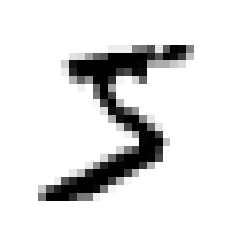

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

In [9]:
#이진 분류기 - 5는 True, 나머지는 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
#확률적 경사하강법(SGD) 분류기로 훈련
from sklearn.linear_model import SGDClassifier  # 한번에 하나씩 훈련 샘플을 독립적으로 처리

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [34]:
# 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

## 교차 검증을 사용한 정확도 측정

In [11]:
#교차 검증 구현
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)   # 계층적 샘플링을 수행

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
#k-fold 교차 검증(k=3)
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
#모든 이미지를 '5아님' 클래스로 분류하여 더미 분류기를 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 오차 행렬

In [15]:
# 실제 타깃과 비교할 수 있도록 먼저 예측값 생성
from sklearn.model_selection import cross_val_predict  # 테스트 폴드에서 얻은 예측을 반환하는 함수

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix  # 오차행렬 함수

confusion_matrix(y_train_5, y_train_pred)  # (타겟 클래스, 예측 클래스)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
# 완벽하게 분류한 데이터
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 정밀도와 재현율
* 정밀도 = 양성예측의 정확도(TP / (TP+FP))
* 재현율 = 분류기가 정확하게 감지한 양성 샘플의 비율,민감도(TP / (TP+FN))

In [18]:
from sklearn.metrics import precision_score, recall_score   # 정밀도, 재현율 함수

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
# F1 점수는 정밀도와 재현율의 조화 평균
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 정밀도/재현율 트레이드오프

In [22]:
y_scores = sgd_clf.decision_function([some_digit])  # 각 샘플의 점수를 얻을 수 있다.
y_scores

array([2164.22030239])

In [25]:
threshold = 0  # 임계값=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [35]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False, ...,  True, False, False])

In [26]:
# 적절한 임계값을 정하기 위해서 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구한다,
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve # 모든 임계값에 대해 정밀도와 재현율을 계산해주는 함수

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

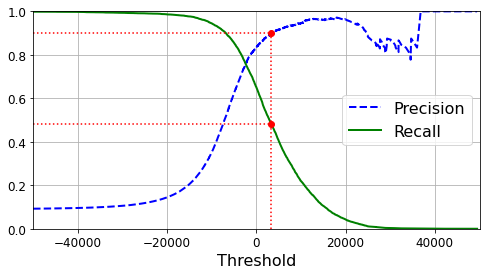

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")               
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                              
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                         
plt.show()

그림 저장: precision_vs_recall_plot


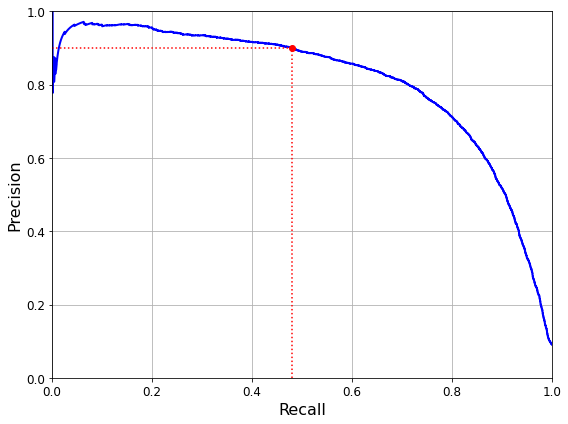

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [37]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [32]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)  # 정밀도 90% 달성

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC 곡선
* 이진 분류에서 널리 사용하는 도구, 정밀도/재현율 곡선과 비슷
* **거짓 양성 비율**(양성으로 잘못 분류된 음성 샘플,FPR)에 대한 **진짜 양성 비율**(재현율)의 곡선
* FPR = 1 - TNR(진짜 음성 비율, 특이도)
* 민감도에 대한 1-특이도 그래프

In [38]:
# roc_curve함수를 사용해 여러 임계값에서 TPR, FPR을 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


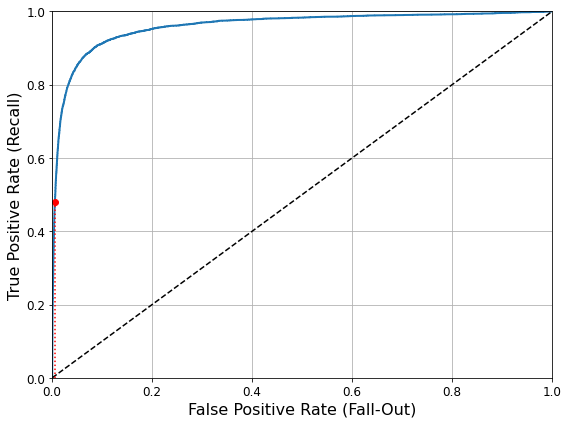

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                        
plt.show()

* 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 합니다
* 곡선아래면적(AUC)을 측정하면 분류기들을 비교
* 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다.

In [40]:
# ROC의 AUC를 계산하는 함수 사용
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [41]:
# 랜덤 포레스트를 훈련시켜 확률적 경사하강법의 ROC곡선과 ROC AUC점수를 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba') # 훈련셋의 샘플에 대한 점수 획득

In [43]:
y_scores_forest = y_proba_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

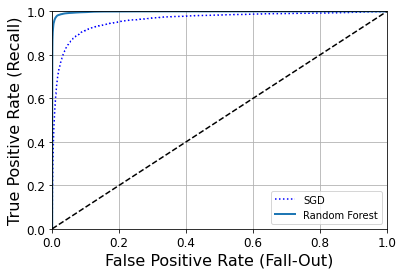

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [46]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [47]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [48]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

# 다중 분류
* 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 되는데 이를 OvR(One versus the Rest)전략이라 한다.
* 또 다른 전략은 0,1 구별, 0,2 구별, 1,2 구별 등 각 숫자의 조합마다 이진 분류기를 훈련시키는 것을 OvO(One versus One)이라 한다.
    - 클래스가 N개라면 N*(N-1)/2 개 필요하다

In [49]:
# 서포트 벡터 머신 분류기
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [51]:
# 내부에서 사이킷런이 OvO전략을 사용해 45개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택했는지 확인
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [52]:
# 결정점수 최댓값 위치(인덱스)확인
np.argmax(some_digit_scores)

5

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
svm_clf.classes_[5]

5

In [56]:
# SVR기반으로 OvR전략을 사용하는 다중 분류기 구현
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
len(ovr_clf.estimators_)

10

In [58]:
# SGD분류기로 훈련
sgd_clf.fit(X_train, y_train) # SGD분류기는 직접 샘플을 다중클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OVR,OVO 적용할 필요 없음
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [59]:
# decision_function메서드는 클래스마다 하나의 값을 반환
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

## 분류기 평가를 위한 교차 검증

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [61]:
# 성능을 더 높이기 위한 입력의 스케일 조정 후 평가
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석
* 가능성이 높은 모델을 하나 찾았다 가장할 때 모델 성늘을 향상키는 방법 중 하나는 에러의 종류를 분석하는 것이다.

In [62]:
# cross_val_predict()로 예측을 만들고 confusion_matrix()함수를 호출
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred) 
conf_mx  # 오차 행렬

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

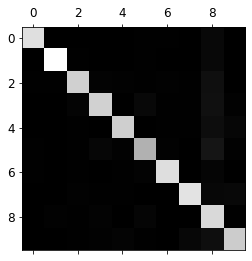

In [63]:
# 오차행렬 시각화
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums   # 오차행렬의 각 값을 대응되는 클래스의 총 이미지 개수로 나누어 에러비율구함

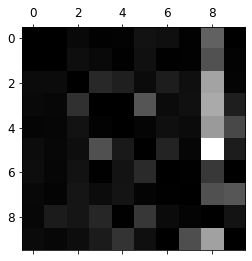

In [66]:
np.fill_diagonal(norm_conf_mx,0) # 주대각선 값 0으로 변환
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 8로 잘못분류된 것들이 꽤 있다는 것을 알 수 있음

* 대부분의 잘못 분류된 이미지는 에러이고 원인은 선형 모델인 SGDClassifier를 사용했기 때문
* 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다.

# 다중 레이블 분류
* 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 **다중 레이블 분류** 시스템이라고 한다.

In [68]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # 두개의 타겟 레이블이 담긴 배열

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [69]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [70]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 다중 출력 분류
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(즉, 값을 두 개 이상 가질 수 있다)

In [73]:
# 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [74]:
# 분류기를 훈련시켜 깨끗한 이미지 출력
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined

# 연습문제

## 1. 97% 정확도의 MNIST 분류기

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## 2. 데이터 증식

In [ ]:
from scipy.ndimage.interpolation import shift
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

## 3. 타이타닉 데이터셋 도전
승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표입니다.

In [ ]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

In [ ]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [ ]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

데이터는 이미 훈련 세트와 테스트 세트로 분리되어 있습니다. 그러나 테스트 데이터는 레이블을 가지고 있지 않습니다: 훈련 데이터를 이용하여 가능한 최고의 모델을 만들고 테스트 데이터에 대한 예측을 캐글(Kaggle)에 업로드하여 최종 점수를 확인하는 것이 목표입니다.

훈련 세트에서 맨 위 몇 개의 열을 살펴 보겠습니다:

In [ ]:
train_data.head()

In [ ]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [ ]:
train_data.info()

In [ ]:
train_data[train_data["Sex"]=="female"]["Age"].median()

In [ ]:
train_data.describe()

수치 특성을 위한 파이프라인부터 시작해서 전처리 파이프라인을 만들어 보죠:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

이제 범주형 특성을 위한 파이프라인을 만듭니다:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

마지막으로 숫자와 범주형 파이프라인을 연결합니다:

In [ ]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

좋습니다! 이제 원본 데이터를 받아 머신러닝 모델에 주입할 숫자 입력 특성을 출력하는 전처리 파이프라인을 만들었습니다.

In [ ]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train